Iteration:      1,   Func. Count:      9,   Neg. LLF: 12236846.178754339
Iteration:      2,   Func. Count:     24,   Neg. LLF: 4332388.539870104
Iteration:      3,   Func. Count:     36,   Neg. LLF: 5827103.604932732
Iteration:      4,   Func. Count:     48,   Neg. LLF: 235542494.81550205
Iteration:      5,   Func. Count:     59,   Neg. LLF: 67194.03952844946
Iteration:      6,   Func. Count:     68,   Neg. LLF: 1152.2136256728857
Iteration:      7,   Func. Count:     78,   Neg. LLF: 9184.47601636883
Iteration:      8,   Func. Count:     88,   Neg. LLF: 1469.2904864634136
Iteration:      9,   Func. Count:     97,   Neg. LLF: 880.4859768268859
Iteration:     10,   Func. Count:    105,   Neg. LLF: 885.9693178789937
Iteration:     11,   Func. Count:    114,   Neg. LLF: 876.3923417349622
Iteration:     12,   Func. Count:    122,   Neg. LLF: 876.3816652511164
Iteration:     13,   Func. Count:    130,   Neg. LLF: 876.3814072735739
Iteration:     14,   Func. Count:    138,   Neg. LLF: 876.381

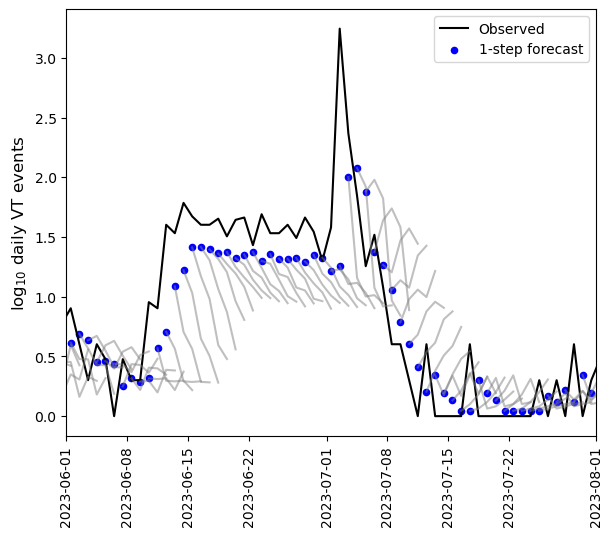

In [11]:
from arch.univariate import arch_model
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# --- Load and prepare data ---
df = pd.read_excel("./data/data_in.xlsx", sheet_name='both')
df = df.dropna().reset_index(drop=True)

date_time = df.pop('date').to_numpy().astype('datetime64[h]')
cutoff = np.where(date_time > np.array('2007-12-31T12',
                                    dtype='datetime64[h]'))[0][0]
df = df.loc[cutoff:].reset_index(drop=True)
date_time = date_time[cutoff:]
df.index = pd.to_datetime(date_time)

# Ensure numeric
df = df.apply(pd.to_numeric, errors='coerce').astype(float)

# use the log10 of seismicity
seis_ = np.log10(df['seismicity'].replace(0, np.nan)).fillna(0)

# split date
split_date = dt.datetime(2020, 1, 1)
y_test = seis_.loc[split_date:]

# --- Fit ARX-GARCH ---
model = arch_model(seis_, mean="ARX", lags=3, vol="GARCH", p=1, q=1)
res = model.fit(last_obs=split_date)

# --- Forecasts ---
forecasts = res.forecast(horizon=5, start=split_date)

# --- Align forecasts with true test data ---
fc_aligned = {}
for col in forecasts.mean.columns:
    h_num = int(col.split(".")[1])  # e.g. "h.1" -> 1
    fc_aligned[col] = forecasts.mean[col].shift(h_num)

fc_aligned = pd.DataFrame(fc_aligned).loc[y_test.index]

# --- Compute R² per horizon ---
r2_per_h = {}
for col in fc_aligned.columns:
    mask = (~fc_aligned[col].isna()) & (~y_test.isna())
    if mask.sum() > 0:
        r2_per_h[col] = r2_score(y_test[mask], fc_aligned[col][mask])
    else:
        r2_per_h[col] = np.nan

print("R² per horizon:")
for h, r2 in r2_per_h.items():
    print(f"{h}: {r2:.3f}")

# --- Plot ---
plt.figure()

# test data in black
plt.plot(y_test.index, y_test, color="black", label="Observed")

# one-step ahead forecasts (h.1) as blue dots
plt.scatter(fc_aligned.index, fc_aligned["h.1"], 
            color="blue", s=20, label="1-step forecast")

# grey lines showing multi-step horizon forecasts
for date in forecasts.mean.index:
    if date in fc_aligned.index:
        vals = fc_aligned.loc[date, :]
        if not vals.isna().all():
            _dates = pd.date_range(start=date, periods=len(vals), freq='D')
            plt.plot(_dates, vals.values, color="grey", alpha=0.5)

plt.legend()

# --- Zoom on period ---
plt.xlim(pd.to_datetime("2023-06-01"), pd.to_datetime("2023-08-01"))

plt.tight_layout()
plt.ylabel('log$_{10}$ daily VT events', fontsize=12)
plt.xticks(rotation=90, ha="center", va="top")

plt.savefig("./selected_figures/GARCH.pdf")
